In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import xgboost as xgb

import os
from joblib import Parallel, delayed

WORK_PATH = '/home/z/Zekang.Zhang'
import sys
sys.path.append(os.path.join(WORK_PATH,'blending_emulator'))
import utils, data_utils, nz_utils

In [2]:
model_path = os.path.join(WORK_PATH,'blending_emulator/models/')

# load xgboost models
bst_cla = xgb.Booster({'device':'cuda','n_jobs':-1})
bst_cla.load_model(os.path.join(model_path,"classification_model_smf50_rescaled_neighbor.json"))

bst_reg = xgb.Booster({'device':'cuda','n_jobs':-1})
bst_reg.load_model(os.path.join(model_path,"regression_model_smf50_normalized_rescaled.json"))

# standardization used in training
[y_mean, y_std] = np.load(os.path.join(model_path,'train_standardization.npy'))
boundaries_reg = np.load(os.path.join(model_path,'train_boundary.npy'))
boundaries_cla = np.load(os.path.join(model_path,'train_boundary_cla_neighbor.npy'))

# standardization used in training
[y_mean, y_std] = np.load(os.path.join(model_path,'train_standardization.npy'))
boundaries_reg = np.load(os.path.join(model_path,'train_boundary.npy'))
boundaries_cla = np.load(os.path.join(model_path,'train_boundary_cla_neighbor.npy'))

In [3]:
def nz_resample(
    redshifts,
    target_nz_det,   # (n_tgt_det_vals, z_grid)
    detec_prob,
    frac=0.25,
    n_bins=100,
    seed=42,
):
    rng = np.random.default_rng(seed)

    # empirical pre-detection n(z) from the catalogue
    pre_counts, pre_z = np.histogram(redshifts, bins=n_bins, density=True)
    pre_centers = 0.5 * (pre_z[1:] + pre_z[:-1])

    n_pre_f     = lambda z: np.interp(z, pre_centers, pre_counts)
    n_tgt_det_f = lambda z: np.interp(z, target_nz_det[1], target_nz_det[0])

    n_pre   = n_pre_f(redshifts)
    n_tgt_d = n_tgt_det_f(redshifts)

    eps = 1e-12
    n_pre = np.clip(n_pre, eps, None)
    p_det = np.clip(detec_prob, eps, None)

    # correct weight:
    weights = n_tgt_d / (n_pre * p_det)

    weights = np.clip(weights, 0, None)
    probs = weights / weights.sum()

    n_samples = int(len(redshifts) * frac)
    sampled_indices = rng.choice(
        len(redshifts),
        size=n_samples,
        replace=True,
        p=probs,
    )
    return sampled_indices


def correct_nz(icat,nz):

    # emulator detections 
    cla_fea = nz_utils.icat2cla(icat,icat,bst_cla,conditions)
    detect_pred = data_utils.xgb_pred(bst_cla, cla_fea)
    del cla_fea

    # removing those detections with at least one neighbor very bright, with a possibility formula
    # detect_pred = utils.remove_detection_w_bright_neighbour_prob(icat_i[['RA','DEC']].values,
                                                            # data_utils.mag2flux(icat_i['r'].values,zero_point),
                                                            # detect_pred,
                                                            # ratio_max=flux_ratio_max,r_min=0,r_max=r_max_neighbour)
    # cla_fea['detection'] = detect_pred
    
    # resample to get the target n(z)
    resampled_idx = nz_resample(icat['redshift'],nz,detec_prob=detect_pred,seed=42)
    reg_fea = nz_utils.icat2reg(icat.iloc[resampled_idx].reset_index(drop=True),icat,bst_reg,conditions)
    
    # detect_pred_ = detect_pred[reg_fea['index_input_p']]
    # reg_fea['detection'] = detect_pred_
    reg_fea['detection'] = np.ones(reg_fea.shape[0]) # detection is already done in the resampling
    
    # emulator responses
    response_pred = data_utils.xgb_pred(bst_reg,reg_fea)
    reg_fea['response'] = data_utils.reverse_standardize(response_pred, y_mean, y_std)
    
    tot_num_bin = resampled_idx.shape[0]
    step_w = np.mean(nz[1][1:]-nz[1][:-1])
    z_lens_bins = np.array([[z_-step_w,z_+step_w] for z_ in nz[1]])
    delta_n = nz_utils.n_correction(reg_fea[bst_reg.feature_names+additional_names],
                                    reg_fea['response'],
                                    z_lens_bins,tot_num_bin)
    return reg_fea,nz[1],delta_n
    
    
gal_path = os.path.join(WORK_PATH,'blending_emulator/example_catalog.feather')

icat = pd.read_feather(gal_path)

conditions = {
    "pixel_size": 0.2,
    "zero_point": 30,
    "psf_fwhm": 0.6,
    "moffat_beta": 2.4,
    "pixel_rms": 6,
}

additional_names = ['RA_input_p',
                    'r_input_p','r_input_s',
                    'Re_input_p','Re_input_s','distance',
                    'sersic_n_input_p', 'sersic_n_input_s',
                    'redshift_input_s','redshift_input_p',
                    'detection']

### Example

In [4]:
nz_z = np.linspace(0, 2, 201)
nz_dz = (nz_z[-1]-nz_z[0])/nz_z.size
dndz = np.exp(-(nz_z-0.7)**2/2/0.1**2)   # assume some simple n(z)
dndz /= (dndz.sum()*nz_dz)

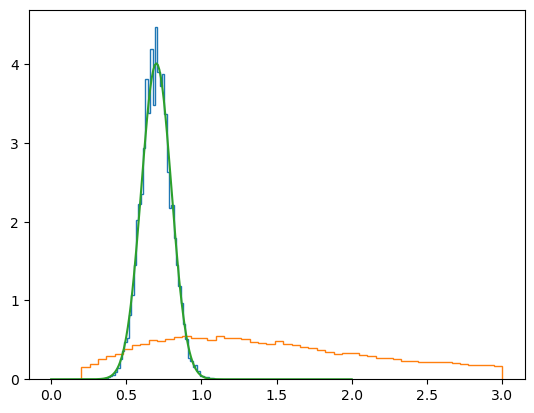

In [5]:
reg_cat,z,delta_n = correct_nz(icat,(dndz,nz_z))
new_nz = dndz + delta_n

plt.hist(reg_cat['redshift_input_p'],bins=50,density=True,histtype='step');
plt.hist(icat['redshift'],bins=50,density=True,histtype='step');
plt.plot(nz_z,dndz);

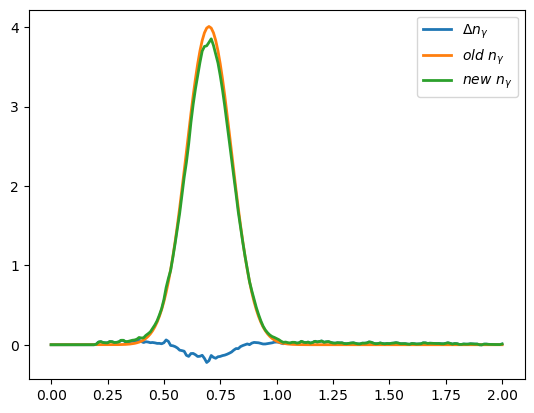

In [6]:
plt.plot(z,delta_n,linewidth=2,label=r'$\Delta n_{\gamma}$');
plt.plot(nz_z,dndz,linewidth=2,label=r'$old~n_{\gamma}$');
plt.plot(nz_z,new_nz,linewidth=2,label=r'$new~n_{\gamma}$');

plt.legend()

### HSC 

In [7]:
from astropy.io import fits

In [8]:
nz_path = WORK_PATH
with fits.open(os.path.join(nz_path,"cosmosis_input_xigtwp_hscy3_Y1ALL_withnpairs2_newbias.fits")) as f:
    nz_data = f[7].data
    f.info()

Filename: /home/z/Zekang.Zhang/cosmosis_input_xigtwp_hscy3_Y1ALL_withnpairs2_newbias.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  COVMAT        1 ImageHDU        17   (695, 695)   float64   
  2  xip           1 BinTableHDU     35   160R x 7C   [K, K, K, D, D, D, D]   
  3  xim           1 BinTableHDU     35   160R x 7C   [K, K, K, D, D, D, D]   
  4  gammat        1 BinTableHDU     35   300R x 7C   [K, K, K, D, D, D, D]   
  5  wp            1 BinTableHDU     35   75R x 7C   [K, K, K, D, D, D, D]   
  6  nz_lens       1 BinTableHDU     31   600R x 8C   [D, D, D, D, D, D, D, D]   
  7  nz_source     1 BinTableHDU     28   60R x 7C   ['D', 'D', 'D', 'D', 'D', 'D', 'D']   


In [9]:
def force_norm(dndz, dz):
    # trapezoidal rule: avg of neighboring dndz times bin width
    norm = ((dndz[:-1] + dndz[1:]) * 0.5 * dz).sum()
    return dndz / norm

bins = ['BIN1','BIN2','BIN3','BIN4']
new_nz = {}
for b in bins:
    _,z,delta_n = correct_nz(icat,(nz_data[b],nz_data['Z_MID']))
    new_nz[b] = force_norm(nz_data[b]+delta_n,z[1:]-z[:-1]) # fake normalization
new_nz['Z_MID'] = z

cols = []
for name in new_nz.keys():
    cols.append(fits.Column(name=name, array=new_nz[name], format='D'))  # D = float64

hdu = fits.BinTableHDU.from_columns(cols)

hdu.writeto(os.path.join(nz_path,"cosmosis_input_xigtwp_hscy3_Y1ALL_withnpairs2_newbias_blending_corrected.fits"), overwrite=True)

In [10]:
with fits.open(os.path.join(nz_path,"cosmosis_input_xigtwp_hscy3_Y1ALL_withnpairs2_newbias_blending_corrected.fits")) as f:
    new_nz = f[1].data
    f.info()

Filename: /home/z/Zekang.Zhang/cosmosis_input_xigtwp_hscy3_Y1ALL_withnpairs2_newbias_blending_corrected.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     18   60R x 5C   ['D', 'D', 'D', 'D', 'D']   


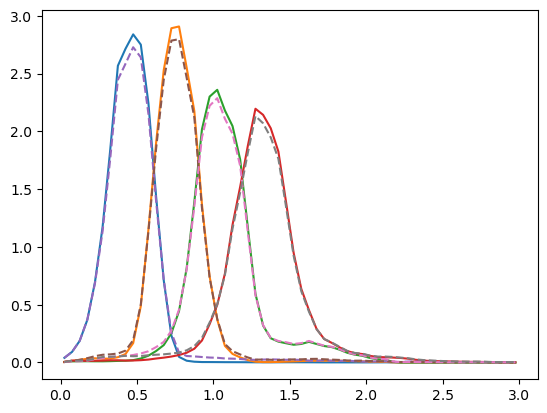

In [11]:
plt.plot(nz_data['Z_MID'],nz_data['BIN1']);
plt.plot(nz_data['Z_MID'],nz_data['BIN2']);
plt.plot(nz_data['Z_MID'],nz_data['BIN3']);
plt.plot(nz_data['Z_MID'],nz_data['BIN4']);

plt.plot(new_nz['Z_MID'],new_nz['BIN1'],linestyle='--');
plt.plot(new_nz['Z_MID'],new_nz['BIN2'],linestyle='--');
plt.plot(new_nz['Z_MID'],new_nz['BIN3'],linestyle='--');
plt.plot(new_nz['Z_MID'],new_nz['BIN4'],linestyle='--');

In [12]:
for b in ['BIN1','BIN2','BIN3','BIN4']:
    old_mean_z = np.trapz(nz_data[b]*nz_data['Z_MID'], nz_data['Z_MID'])
    new_mean_z = np.trapz(new_nz[b]*new_nz['Z_MID'], new_nz['Z_MID'])
    delta_mean_z = new_mean_z - old_mean_z
    print(f"{b}: old mean z = {old_mean_z:.4f}, new mean z = {new_mean_z:.4f}, \Delta mean z = {delta_mean_z:.4f}")

BIN1: old mean z = 0.4515, new mean z = 0.4853, \Delta mean z = 0.0338
BIN2: old mean z = 0.7663, new mean z = 0.7772, \Delta mean z = 0.0109
BIN3: old mean z = 1.0815, new mean z = 1.0762, \Delta mean z = -0.0053
BIN4: old mean z = 1.3292, new mean z = 1.3152, \Delta mean z = -0.0140
